# Pairs trading strategy for the Forex markets

This notebook's objective is to construct a statistical arbitrage trading strategy, namely through pairs trading. We take advantage of two currency pairs that are cointegrated, which in other words means pairs that exhibit reversion to the mean. Once we determine the combinations of currency pairs that demonstrate this behaviour, we may trade both pairs at the same time once we notice them diverging from their relative mean, in hopes it will return.

## Identifying cointegration

We know that $x_t$ and $y_t$ are cointegrated if $x_t$ and $y_t$ are $I(1)$ series and $\exists \beta$ such that $z_t=x_t-\beta y_t$ is an $I(0)$ series (is stationary).

To identify cointegration between two currency pairs, we first assume that $\beta$ is constant. We may calculate this $\beta$ using regression such that the spread ($z_t$) is as close to 0 as possible.

First we import the relevant libraries,

In [3]:
#%pip install statsmodels 
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import itertools
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress

Create function to import data from yahoo finance

In [4]:
def download_data(ticker, start, end):
    fx_data = {}
    pair = yf.download(ticker, start, end)
    fx_data[f'{ticker}'] = pair['Adj Close']
    return pd.DataFrame(fx_data)

For this notebook we will use only major and minor Forex pairs, with data from 2016 to the current day (rewrite this when i use 2001->2016 and train then 2016->current as test)

In [85]:
currencies = ['USDCAD=X','USDCHF=X','EURJPY=X','GBPCAD=X','NZDCAD=X','NZDCHF=X','AUDNZD=X','GBPUSD=X','AUDCHF=X','GBPCHF=X','EURNZD=X','GBPNZD=X','AUDCAD=X','AUDUSD=X','EURUSD=X','CADJPY=X','NZDJPY=X','EURCAD=X','AUDJPY=X','EURCHF=X','EURAUD=X','CADCHF=X','GBPAUD=X','NZDUSD=X','USDJPY=X','CHFJPY=X','EURGBP=X','GBPJPY=X']
start_train=datetime.datetime(2016,1,1)
end_train=datetime.datetime(2020,1,6)

In [86]:
prices_data=pd.concat([download_data(i,start_train,end_train) for i in currencies],axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Yahoo finance is quite tempromental and has a few instances of certain pairs having no data for that day. These "na" values will be filled in with the last closing price, staying reasonably consistent.

In [87]:
prices_data=prices_data.fillna(method='ffill')

Here is our data,

In [8]:
prices_data

,USDCAD=X,USDCHF=X,EURJPY=X,GBPCAD=X,NZDCAD=X,NZDCHF=X,AUDNZD=X,GBPUSD=X,AUDCHF=X,GBPCHF=X,...,AUDJPY=X,EURCHF=X,EURAUD=X,CADCHF=X,GBPAUD=X,NZDUSD=X,USDJPY=X,CHFJPY=X,EURGBP=X,GBPJPY=X
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,1.06193,0.89269,144.750000,1.75818,0.87123,0.73219,1.08287,1.656397,0.79570,1.47806,...,93.769997,1.22720,1.54086,0.83983,1.85646,0.822707,105.300003,117.830002,0.82973,174.300003
2014-01-02,1.06445,0.89150,145.011002,1.76450,0.87303,0.73120,1.08300,1.658072,0.79240,1.47780,...,93.619003,1.22725,1.54810,0.83700,1.86410,0.820883,105.323997,118.121803,0.83040,174.593002
2014-01-03,1.06691,0.89914,143.257004,1.75463,0.87310,0.73580,1.08756,1.644791,0.80050,1.47864,...,93.350998,1.22873,1.53410,0.84256,1.84630,0.818733,104.833000,116.556396,0.83079,172.403000
2014-01-06,1.06305,0.90503,142.626007,1.74410,0.87844,0.74782,1.08400,1.641309,0.81110,1.48510,...,94.041000,1.23050,1.51653,0.85112,1.83000,0.826720,104.912003,115.870003,0.82850,172.138000
2014-01-07,1.06609,0.90376,142.044998,1.74978,0.88338,0.74857,1.08142,1.641794,0.81032,1.48343,...,93.425003,1.23177,1.51999,0.84751,1.83048,0.828981,104.209999,115.279999,0.83014,171.056000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26,1.35860,0.98610,126.001999,1.72340,0.91411,0.66357,1.04679,1.268875,0.69482,1.25081,...,77.779999,1.12561,1.61976,0.72576,1.80060,0.673020,110.402000,111.920998,0.89949,140.052994
2018-12-27,1.35730,0.99430,126.404999,1.71637,0.91462,0.66997,1.04960,1.264878,0.70352,1.25736,...,78.667999,1.12964,1.60578,0.73245,1.78754,0.673982,111.206001,111.896004,0.89816,140.695999
2018-12-28,1.36190,0.98690,126.767998,1.72179,0.91190,0.66119,1.04988,1.264622,0.69443,1.24813,...,77.981003,1.12831,1.62482,0.72462,1.79738,0.670021,110.855003,112.290001,0.90386,140.205994


Now that we have our dataframe, we may calculate $z_t=x_t-\beta y_t$ and use the augmented Dickey–Fuller to test the null hypothesis that a unit root is present in a time series $z_t$. If we can reject the null hypothesis that a unit root is not present, it follows that it is stationary and hence exhibits reversion to the mean. This implies our two pairs $x_t$ and $y_t$ are cointegrated.

In [95]:
def cointegratedpairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    cointpairs=[]
    for i in range(n):
        for j in range(i+1, n):
            result = linregress(data.values[:, i], data.values[:, j]) # Perform a linear regression
            residuals = data.iloc[:,i] - result.slope * data.iloc[:,j]
            adf=ts.adfuller(residuals)
            pvalue_matrix[i, j] = adf[1]
            if adf[1] < 0.01:
                cointpairs.append((currencies[i], currencies[j]))
    return pvalue_matrix, cointpairs

We append all the sets of pairs that have a p-value of 0.05 or less, with high confidence that they are cointegrated.

In [96]:
pvalues,cointpairs = cointegratedpairs(prices_data)

We can plot all the pvalues in a heatmap to better illustrate cointegration between major and minor forex pairs,

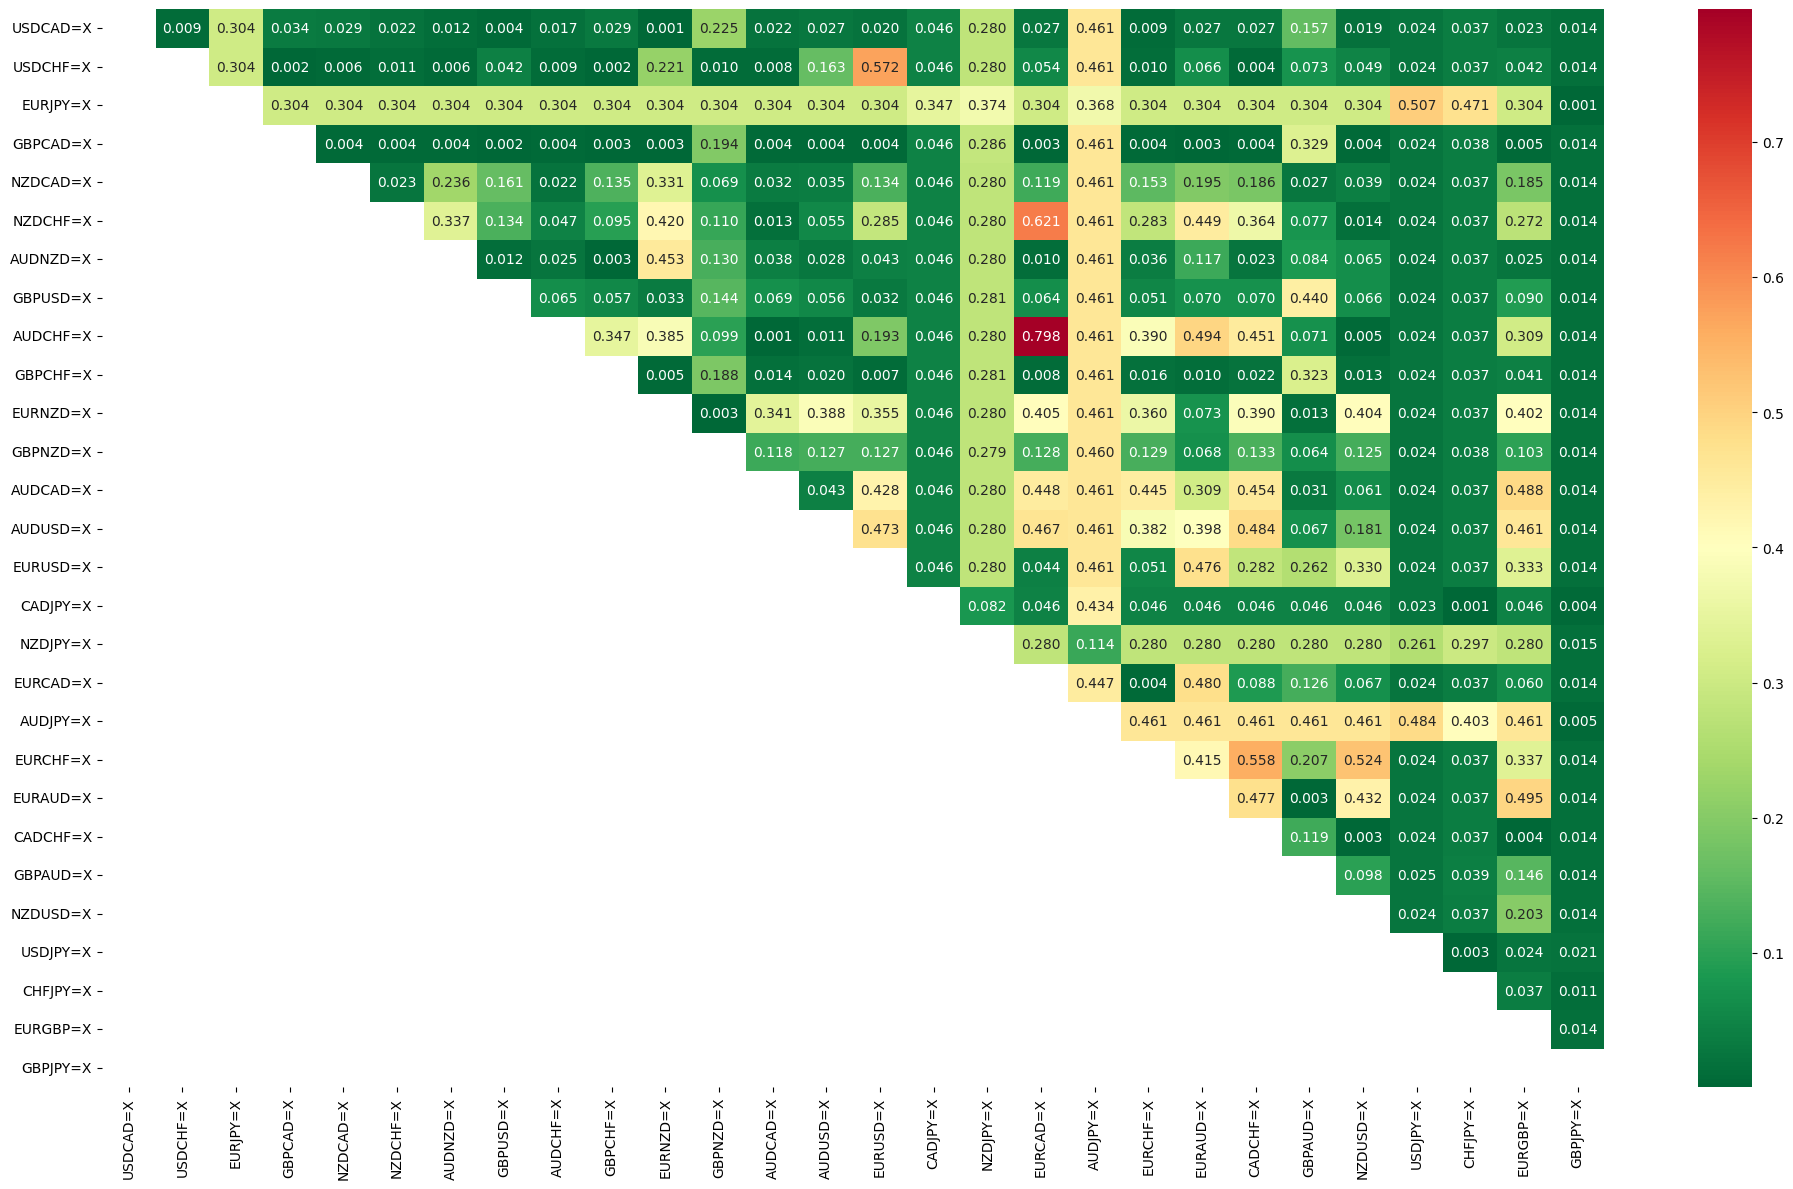

In [97]:
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(pvalues, xticklabels = currencies, yticklabels = currencies, cmap = 'RdYlGn_r', annot = True, fmt=".3f",mask = (pvalues == 1))
plt.tight_layout()

Correlation can also be important. A correlation coefficient is a statistic that provides a measure how the two pairs are associated. We require generally correlated pairs so that they follow similar trends in usual cases.

<AxesSubplot:>

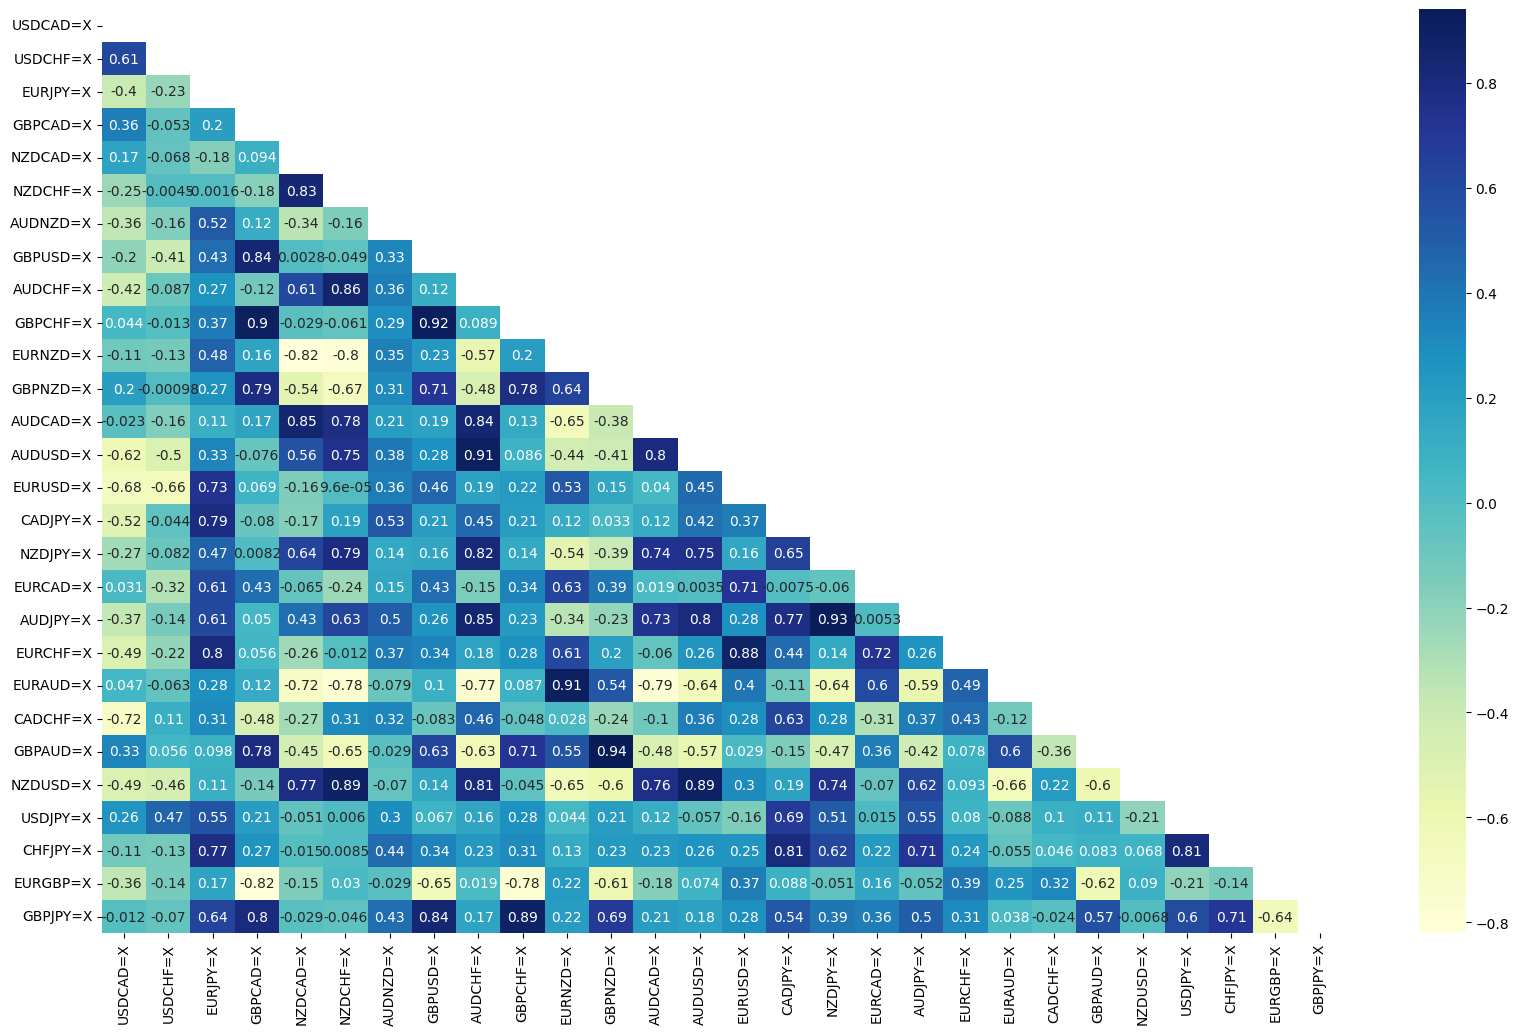

In [98]:
corr=prices_data.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
fig, ax = plt.subplots(figsize=(20,12))

sns.heatmap(corr, cmap="YlGnBu", annot=True, mask=mask)

We create a correlation filter in order to extract correlated pairs. This is set arbitrarily to 0.8,

In [147]:
corrpairs=[]
for i in range(corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if abs(corr.iloc[i][j])>=0.9 and i!=j:
            corrpairs.append((corr.columns[i],corr.index[j]))

In [148]:
sorted_corrpairs = [tuple(sorted(corrpairs[i])) for i in range(len(corrpairs))]
sorted_cointpairs = [tuple(sorted(cointpairs[i])) for i in range(len(cointpairs))]

Sort the tuples such that they are in alphabetical order so we can find the intersection of our two lists,

In [149]:
strategy_pairs = set(sorted_corrpairs).intersection(set(sorted_cointpairs))
print(strategy_pairs)

{('GBPCAD=X', 'GBPCHF=X')}


We may now view the price data in a scatter plot to better view the correlation,

In [111]:
def scatter_plot(data1, data2,data1name,data2name):
    
    plt.scatter(data1.values, data2.values)
    plt.xlabel(f'{data1name}')
    plt.ylabel(f'{data2name}')
    plt.show()

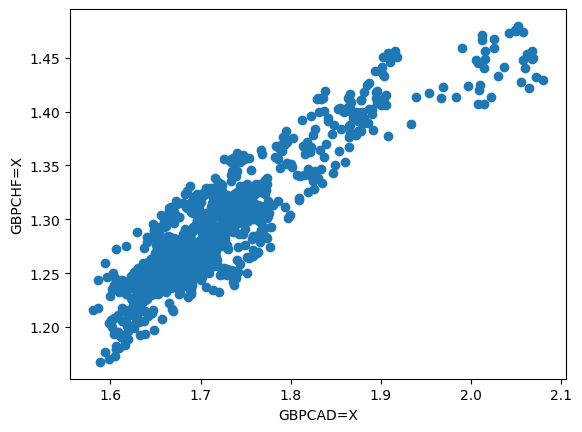

In [112]:
for i in strategy_pairs:
    scatter_plot(prices_data.loc[:,i[0]],prices_data.loc[:,i[1]], i[0], i[1])

## Forming the strategy

Since we now have sets of $x_t$ and $y_t$ cointegrated pairs such that $x_t - \beta y_t = I(0)$, we may use this spread to form our signals on since it will exhibit mean reverting behaviour. 

We wish to identify when this stationary time series is reasonably away from the mean, to create a signal and expect it to return. Given our spread $(\text{Pair 1}) - \beta \ (\text{Pair 2})$, when it is reasonably above the mean, we will sell Pair 1 and buy Pair 2, in order for this spread to decrease and revert towards its mean, at which point we will close our positions.

To avoid overfitting, we will test our strategy on a new set of data from 2020 to today,

In [113]:
start_date_test = datetime.datetime(2020, 1, 6)
end_date_test = datetime.datetime(2022, 10, 10)

prices_data_test = pd.concat([download_data(i,start_date_test,end_date_test) for i in currencies],axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [73]:
prices_data_test=prices_data_test.fillna(method='ffill')

### Z-score signals

In order to create the signals of when to enter a trade, we normalize the spread by defining its z-score. This will tell us how many standard deviations away from the mean our price is. This part is set arbitrarily such that when the z score is less than -1 or above 1, a signal is created. In other words, when the spread of our two cointegrated pairs reaches one standard deviation above or below the mean, we create a trading signal.

We first create a dataframe containing all relevant data,

In [20]:
def zscore(priceseries):
    return(priceseries - priceseries.mean())/np.std(priceseries)

def signals_dataframe(ticker1,ticker2):

    pair1=prices_data_test.loc[:,f"{ticker1}"]
    pair2=prices_data_test.loc[:,f"{ticker2}"]
    hedgeratio = linregress(prices_data_test.loc[:,f"{ticker1}"], prices_data_test.loc[:,f"{ticker2}"]).slope
    
    signals = pd.DataFrame(pair1.values-hedgeratio*pair2.values,columns=['spread'],index=prices_data_test.index)

    signals['pair1'] = pair1.values
    signals['pair2'] = pair2.values

    signals['z'] = zscore(signals.spread)
    signals['z_upper']=1
    signals['z_lower']=-1
    return signals

We can visualise our spread's z-score with the upper and lower bands as follows,

In [21]:
def plot_zscore(signals):
    fig, ax = plt.subplots()
    fig.set_size_inches(25, 6)
    ax.plot(signals['z'], label='z  score', color='black')
    ax.plot(signals['z_upper'], label='upper', color='green')
    ax.plot(signals['z_lower'], label='lower', color='red')
    
    ax.legend()

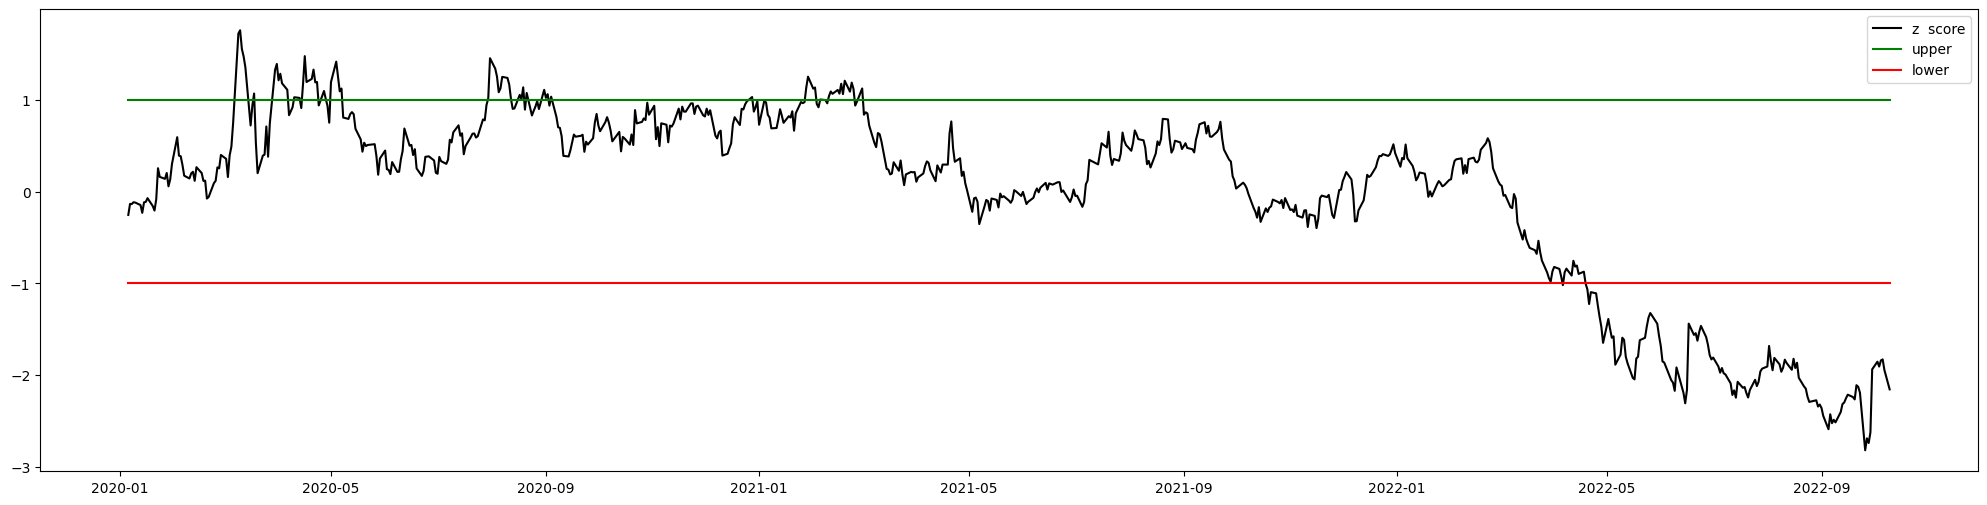

In [139]:
GCGC=signals_dataframe("GBPCAD=X","GBPCHF=X")

plot_zscore(GCGC)

When the z score falls beneath the lower band, we see this as a signal to long 'pair1' (GBP/CAD) and short 'pair2' (GBP/CHF). Conversely, when the z score reaches above the upper band, this is a signal to short 'pair1' (GBP/CAD) and short 'pair2' (GBP/CHF). The point at which the z-score returns to the "inner band" of [-1,1], we close the trade.

### Possible issues

A problem that can arise is the failure of cointegration, if this occurs, it completely dismantles the foundation of the strategy, and will lead to considerable losses. You can see that the end of $\frac{GBP/CAD}{GBP/CHF}$ is beginning to display a breakdown of its previously mean reverting behaviour. This is an important fact to consider, and must be monitored as time progresses. Perhaps with persistent augmented Dickey–Fuller tests, even on varying time-frames.

## Backtesting

We may use np.select to create the signal from our z-score. We then use the first order differencing function to find when each position is bought or sold.

Then, assuming we are using no leverage, we will place all our funds (100,000) into our first position (just as if it were a stock portfolio). This is split evenly for each pair (50,000 each), and we can find our position size for each order from this.

In [120]:
initial_capital = 50000

def backtest(ticker1,ticker2):

    signals=signals_dataframe(ticker1,ticker2)
    
    signals['signals_pair1'] = np.select([signals['z'] > signals['z_upper'], signals['z'] < signals['z_lower']], [-1, 1], default=0)
    signals['signals_pair2'] = -signals['signals_pair1']

    signals['position_pair1'] = signals['signals_pair1'].diff()
    signals['position_pair2'] = signals['signals_pair2'].diff()
    
    pair1_possize = initial_capital / signals.pair1[0]
    pair2_possize = initial_capital / signals.pair2[0]
    
    portfolio = pd.DataFrame()
    portfolio['pair1'] = signals['pair1']
    portfolio['holdings1'] = signals['signals_pair1'] * signals['pair1'] * pair1_possize
    portfolio['cash1'] = initial_capital - (signals['position_pair1'] * signals['pair1'] * pair1_possize).cumsum()
    portfolio['total pair1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total pair1'].pct_change()

    portfolio['pair2'] = signals['pair2']
    portfolio['holdings2'] = signals['signals_pair2'] * signals['pair2'] * pair2_possize
    portfolio['cash2'] = initial_capital - (signals['position_pair2'] * signals['pair2'] * pair2_possize).cumsum()
    portfolio['total pair2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total pair2'].pct_change()
    
    portfolio['daily_returns']= portfolio['return1'] + portfolio['return2']
    portfolio['total_pairs'] = portfolio['total pair1'] + portfolio['total pair2']
    
    return portfolio,signals

We may plot the individual trades taken,

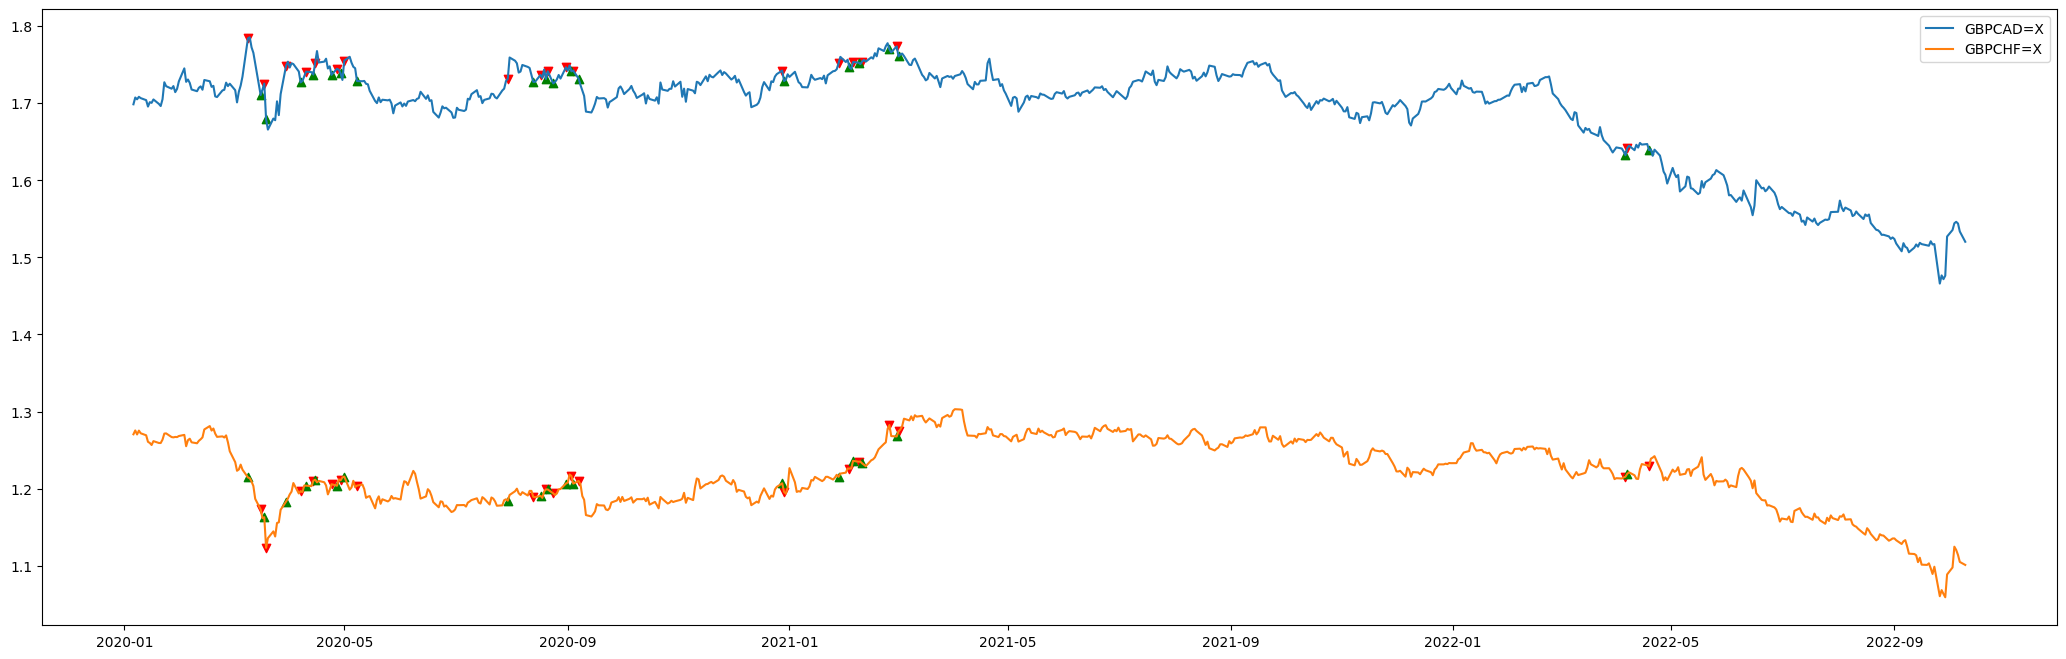

In [115]:
def plotpositions(ticker1,ticker2):
    
    signals=backtest(ticker1,ticker2)[1]
    
    buymarkers,sellmarkers=[],[]
    
    for i in range(len(signals.position_pair1)):
        if signals.position_pair1[i]==1:
            buymarkers.append(signals.pair1[i])
            sellmarkers.append(signals.pair2[i])
        elif signals.position_pair1[i]==-1:
            buymarkers.append(signals.pair2[i])
            sellmarkers.append(signals.pair1[i])
        else:
            buymarkers.append(np.nan)
            sellmarkers.append(np.nan)

    signals['buymarkers']=buymarkers
    signals['sellmarkers']=sellmarkers

    fig, ax = plt.subplots()
    fig.set_size_inches(26, 8)
    ax.plot(signals.pair1,label=ticker1)
    ax.plot(signals.pair2,label=ticker2)

    ax.scatter(signals.index,signals.sellmarkers,marker="v",color="red")
    ax.scatter(signals.index,signals.buymarkers,marker="^",color="green")
    ax.legend()

plotpositions("GBPCAD=X","GBPCHF=X")

We will calculate the Compound Annual Growth Rate and sharpe ratio to view the effectiveness of this strategy,

In [134]:
def equitycurve_and_metrics(ticker1,ticker2):
    
    portfolio = backtest(ticker1,ticker2)[0]
    
    fig, ax = plt.subplots()
    
    ax.plot(portfolio.total_pairs)
    ax.set_xlabel("Time")
    ax.set_ylabel("Equity")
    ax.set_title(f"Equity curve for pairs strategy with {ticker1} and {ticker2}");
    
    final_balance = portfolio['total_pairs'].iloc[-1]
    days_elapsed = (portfolio.index[-1] - portfolio.index[0]).days
    returns = (final_balance/(initial_capital * 2)) ** (365/days_elapsed) - 1
    print("Compound Annual Growth Rate: %.2f" % (returns*100) + "%")
    
    sharpe = portfolio['daily_returns'].mean()/portfolio['daily_returns'].std() * 365**0.5
    print("Sharpe ratio: %.2f" % sharpe)

Since we have written functions to do most of the work here, we may see the results for all our cointigrated and correlated combinations of pairs. For our train and test set this is only one set of pairs, but I would like to have this code be versatile for future use and research,

Compound Annual Growth Rate: 3.25%
Sharpe ratio: 1.72


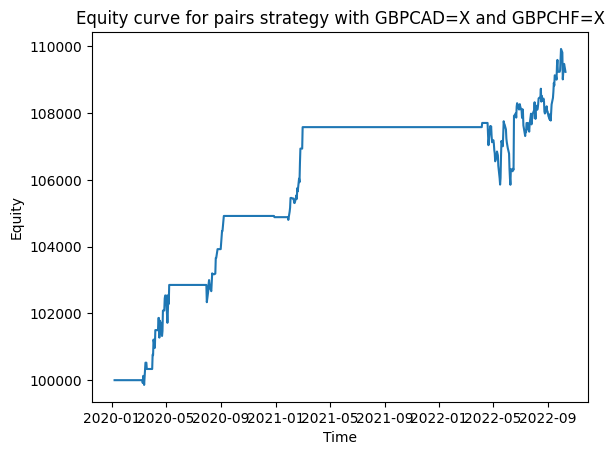

In [150]:
for i in strategy_pairs:
    equitycurve_and_metrics(i[0],i[1])

## Concluding remarks

Compounding of profits was not taken into account within this backtest, since a static position size was taken based on the initial price and balance. As such, we can expect higher annual gains in such a scenario. Also, with such a high sharpe ratio, it may be in our best interest to take advantage of leverage which is common in trading Forex. This would also lead to substantially higher returns.

Pairs trading on the forex markets has confirmed be viable for pairs involving an identical quote currrency. Forming signals using the spread of two price series' has the same result as trading the ratio of the two: Identifying changes in the difference between the two assets. In that sense, pairs trading on forex pairs can be identical to just trading using the z-score of the differing currencies in each pairs. For example, the price ratio $\frac{GBP/CAD}{GBP/CHF}$ is (assuming no pricing inneficiencies), the same as the price of CHF/CAD. So in retrospect, pairs trading seems to be generally better to perform on other assets that dont already come in pairs, such as stocks.

As mentioned before, the main underlying issue with pairs trading using past cointegration measures is that this does not necessarily imply that it will be in the future. As such, it is possible that the mean reversion will break down. Our constructed spread typically reverts when random, non-structural events affect the values of $x_t$ and $y_t$. However, when structural events occurs, such as a major economic event, the stationarity of our spread may break down severely. An example of a major structural event is the COVID pandemic, which I purposefully chose not to be in my testing set for this reason.

Predicting the breakdown of a spread is very hard, however by following economic events of the currencies you are trading, this may provide a forewarning of a loss of cointegration. By understanding the relationship, we may be in a better position to tell when and why a spread may break down. Another way to mitigate the risk of such a breakdown of strategy is to diversify. This seems like a futile effort for the currency markets since for our example here, only one set of pairs was selected, but it is a possibility when applying this strategy to other markets, such as with stocks or ETFs.

A future project could be the implementation of this into some stocks in similar industries, however I can imagine the selection phase in finding the cointegration statistics quite lengthy, in testing all stock combinations.